In [1]:
import matplotlib.pyplot as plt
import os

if not os.path.exists('data'):
    new_directory_path = "..\\..\\"
    os.chdir(new_directory_path)
import torch

torch.Size([13, 2, 1])
torch.Size([2])


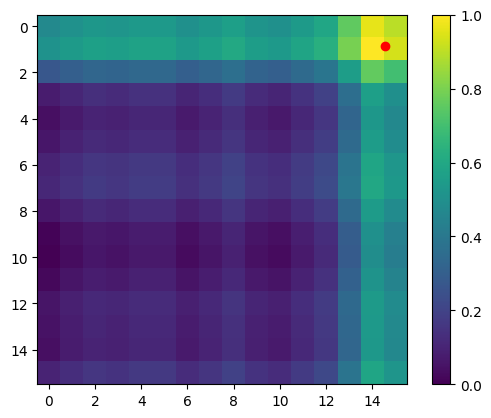

In [2]:
rescale = 2
x = torch.rand((13,2)).unsqueeze(-1)*rescale
B = torch.randn((2, 100))
# [13,2,60]
projected = (2 * torch.pi * x) * B
# [13,2,120]
projected = projected.flatten(start_dim=-2)
# [13,2,240]
x_proj = torch.cat([torch.sin(projected), torch.cos(projected)], dim=-1)

coords = torch.arange(.5,16)/16*rescale
ii,jj = torch.meshgrid(coords,coords, indexing = 'xy')
coords = torch.stack([ii,jj], dim = -1)
coords = coords.unsqueeze(-1)
coords.shape
projected = (2 * torch.pi * coords) * B
# [13,120]
projected = projected.flatten(start_dim=-2)
# [13,240]
img_proj = torch.cat([torch.sin(projected), torch.cos(projected)], dim=-1)
sim = img_proj@x_proj.transpose(0,1)

idx = torch.randint(0,13,(1,))[0]
print(x.shape)
item_coords = (x[idx,:,0]*16 - 0.5)/rescale
print(item_coords.shape)
plt.scatter(item_coords[0], item_coords[1], color = 'red')
plt.colorbar()
plt.imshow(sim[:,:,idx])


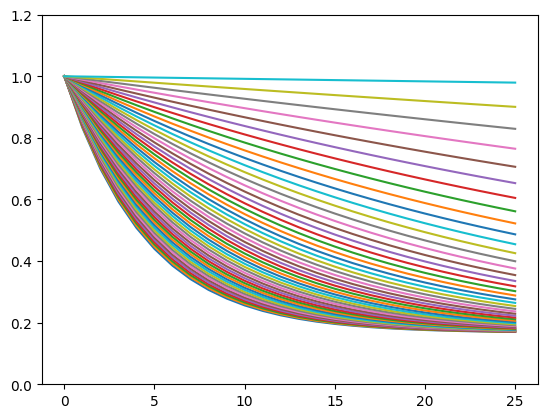

In [3]:
x = torch.arange(26)
b = 0.8
plt.ylim(0, 1.2)
b = torch.linspace(0.8,0.999,50)
alpha = 5
for i in range(50):
    y = (alpha* (b[i]**x) + 1)/(1 + alpha)
    plt.plot(x,y)
plt.show()

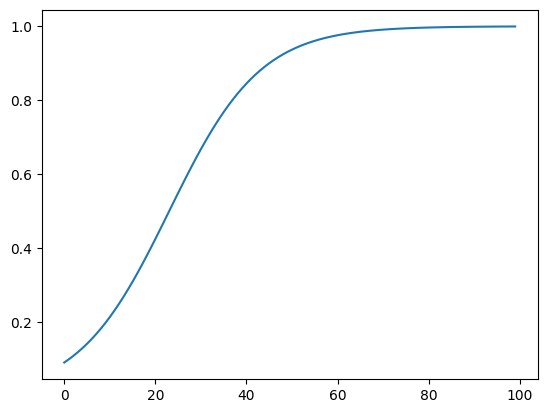

In [7]:
epochs = torch.arange(0,100)
k = 10
epsilon = k / (k + torch.exp(epochs / k))
plt.plot(epochs,1 - epsilon)

In [8]:
import torch
from torch.optim.lr_scheduler import _LRScheduler
import math

class WarmupStableDecayScheduler(_LRScheduler):
    def __init__(self, optimizer, warmup_steps, stable_steps, decay_steps, min_lr=1e-6, last_epoch=-1):
        self.warmup_steps = warmup_steps
        self.stable_steps = stable_steps
        self.decay_steps = decay_steps
        self.min_lr = min_lr
        self.total_steps = warmup_steps + stable_steps + decay_steps
        super(WarmupStableDecayScheduler, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        step = self.last_epoch
        
        # 1. Warmup Phase: Linear increase from 0 to base_lr
        if step < self.warmup_steps:
            factor = float(step) / float(max(1, self.warmup_steps))
            return [base_lr * factor for base_lr in self.base_lrs]
        
        # 2. Stable Phase: Constant base_lr
        # This is where you should ramp up your Scheduled Sampling
        elif step < self.warmup_steps + self.stable_steps:
            return [base_lr for base_lr in self.base_lrs]
        
        # 3. Decay Phase: Cosine decay to min_lr
        else:
            # How far are we into the decay phase?
            decay_step = step - (self.warmup_steps + self.stable_steps)
            decay_step = min(decay_step, self.decay_steps) # Cap it
            
            cosine_decay = 0.5 * (1 + math.cos(math.pi * decay_step / self.decay_steps))
            
            return [
                self.min_lr + (base_lr - self.min_lr) * cosine_decay
                for base_lr in self.base_lrs
            ]
            
import torch.nn as nn
import torch.optim as optim

# --- Configuration ---
dim = 128
model = nn.Linear(dim, dim) # Dummy model
optimizer = optim.Adam(model.parameters(), lr=1e-3) # Max LR is 1e-3

# Define the schedule durations
WARMUP = 1000
STABLE = 5000   # <--- Ramp up sampling here
DECAY = 4000

scheduler = WarmupStableDecayScheduler(
    optimizer, 
    warmup_steps=WARMUP, 
    stable_steps=STABLE, 
    decay_steps=DECAY,
    min_lr=1e-6
)

# --- Training Loop ---
for step in range(WARMUP + STABLE + DECAY):
    
    # 1. Calculate Sampling Probability (Linear Ramp during STABLE phase)
    # If we are in warmup, Keep it 0 (Teacher Forcing)
    # If we are in stable, ramp from 0.0 to 1.0 (or your target max)
    if step < WARMUP:
        sampling_prob = 0.0
    elif step < (WARMUP + STABLE):
        # Progress 0.0 to 1.0 within the stable window
        progress = (step - WARMUP) / STABLE 
        sampling_prob = progress * 0.5 # Example: Ramp to max 50% sampling
    else:
        sampling_prob = 0.5 # Keep constant during decay
        
    # 2. Standard Training Steps
    optimizer.zero_grad()
    
    # Pass sampling_prob to your model forward pass
    # output = model(input, sampling_prob=sampling_prob)
    # loss = criterion(output, target)
    # loss.backward()
    
    optimizer.step()
    
    # 3. Update Scheduler
    scheduler.step()
    
    current_lr = scheduler.get_last_lr()[0]
    
    if step % 1000 == 0:
        print(f"Step {step}: LR={current_lr:.5f}, Sampling Prob={sampling_prob:.2f}")

Step 0: LR=0.00000, Sampling Prob=0.00
Step 1000: LR=0.00100, Sampling Prob=0.00
Step 2000: LR=0.00100, Sampling Prob=0.10
Step 3000: LR=0.00100, Sampling Prob=0.20
Step 4000: LR=0.00100, Sampling Prob=0.30
Step 5000: LR=0.00100, Sampling Prob=0.40
Step 6000: LR=0.00100, Sampling Prob=0.50
Step 7000: LR=0.00085, Sampling Prob=0.50
Step 8000: LR=0.00050, Sampling Prob=0.50
Step 9000: LR=0.00015, Sampling Prob=0.50
